# Causal analysis Temperature vs $CO_2$ Concentration

![Causality](img/causality.jpeg)

This work is related carbon dioxide concentration on the atmosphere and the temperature evolution throughout the years in the world.

In this part of the analysis, it is going to be presented a causal analysis between the two features:

 - **Temperature**              
 - **$CO_2$ Concentration**

It is presented in the following sections:

1. Data Loading
2. Data Exploratory
3. Summary statistics
4. Modelling Time Series (VAR - Vector Autoregression)
5. Conclusion

In [101]:
############# Setting up Env #############
## RUN THIS CELL ONLY IF YOU DO NOT HAVE## 
## YOUR DEVELOPMENT ENVIRONMENT SET UP  ##
############# Setting up Env #############

# Uncomment the lines below
# import sys
# !{sys.executable} -m pip install -r requirements.txt

In [101]:
import numpy as np 
import pandas as pd
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import VAR
from statsmodels.tsa.seasonal import STL
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Data Loading

Both datasets can be found in the folder [data](/data).

In [2]:
# Loading the data for global temperature
temp = pd.read_csv('data/GlobalLandTemperaturesByCity.csv', infer_datetime_format=True)
df = temp.copy()
df.dt = df.dt.apply(pd.to_datetime)
df['Month'] = df['dt'].dt.month
df['Year'] = df['dt'].dt.year
df = df[df.Year >= 1900]
df.set_index('dt', inplace=True)
df.head()

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,Month,Year
dt,,,,,,,,
1900-01-01,-0.989,0.588,Århus,Denmark,57.05N,10.33E,1,1900
1900-02-01,-2.799,0.882,Århus,Denmark,57.05N,10.33E,2,1900
1900-03-01,0.592,0.429,Århus,Denmark,57.05N,10.33E,3,1900
1900-04-01,4.630,0.417,Århus,Denmark,57.05N,10.33E,4,1900
1900-05-01,9.576,0.521,Århus,Denmark,57.05N,10.33E,5,1900


In [5]:
# Loading the data for co2 concentration
co2 = pd.read_csv('data/mole_fraction_of_carbon_dioxide.csv')
YEAR_START = 1900
df2 = co2[co2.year >= YEAR_START]
df2.index = (df2.year.astype(str).apply(lambda x: x.zfill(4)) + 
    "-" + 
   df2.month.astype(str).apply(lambda x: x.zfill(2)) +
    "-01"
)
df2.index = pd.to_datetime(df2.index)
df2 = df2.drop(['datenum', 'datetime', 'day'], axis=1)
df2.head()

,year,month,data_mean_global,data_mean_nh,data_mean_sh
1900-01-01,1900,1,296.205964,297.023130,295.388798
1900-02-01,1900,2,296.614810,297.706181,295.523438
1900-03-01,1900,3,296.980286,298.371424,295.589149
1900-04-01,1900,4,297.243354,298.924514,295.562195
1900-05-01,1900,5,297.204653,298.835449,295.573858


In [11]:
causal_df = pd.merge(df, df2, left_on=df.index, right_on=df2.index)
causal_df = causal_df.set_index('key_0')
causal_df.head()

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,Month,Year,year,month,data_mean_global,data_mean_nh,data_mean_sh
key_0,,,,,,,,,,,,,
1900-01-01,-0.989,0.588,Århus,Denmark,57.05N,10.33E,1,1900,1900,1,296.205964,297.02313,295.388798
1900-01-01,5.763,1.008,Çorlu,Turkey,40.99N,27.69E,1,1900,1900,1,296.205964,297.02313,295.388798
1900-01-01,0.947,0.771,Çorum,Turkey,40.99N,34.08E,1,1900,1900,1,296.205964,297.02313,295.388798
1900-01-01,-25.819,1.058,Öskemen,Kazakhstan,50.63N,82.39E,1,1900,1900,1,296.205964,297.02313,295.388798
1900-01-01,-20.970,1.505,Ürümqi,China,44.20N,87.20E,1,1900,1900,1,296.205964,297.02313,295.388798


In [8]:
# Checking for null values
causal_df[causal_df.isnull().any(axis=1)]

,key_0,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,Month,Year,year,month,data_mean_global,data_mean_nh,data_mean_sh
4787640,2013-09-01,NaN,NaN,Århus,Denmark,57.05N,10.33E,9,2013,2013,9,393.58852,392.913184,394.263855
4787641,2013-09-01,NaN,NaN,Çorlu,Turkey,40.99N,27.69E,9,2013,2013,9,393.58852,392.913184,394.263855
4787642,2013-09-01,NaN,NaN,Çorum,Turkey,40.99N,34.08E,9,2013,2013,9,393.58852,392.913184,394.263855
4787643,2013-09-01,NaN,NaN,Öskemen,Kazakhstan,50.63N,82.39E,9,2013,2013,9,393.58852,392.913184,394.263855
4787644,2013-09-01,NaN,NaN,Ürümqi,China,44.20N,87.20E,9,2013,2013,9,393.58852,392.913184,394.263855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4791145,2013-09-01,NaN,NaN,Zouxian,China,36.17N,117.35E,9,2013,2013,9,393.58852,392.913184,394.263855
4791146,2013-09-01,NaN,NaN,Zunyi,China,28.13N,106.36E,9,2013,2013,9,393.58852,392.913184,394.263855
4791147,2013-09-01,NaN,NaN,Zurich,Switzerland,47.42N,8.29E,9,2013,2013,9,393.58852,392.913184,394.263855
4791148,2013-09-01,NaN,NaN,Zuwarah,Libya,32.95N,12.45E,9,2013,2013,9,393.58852,392.913184,394.263855


In [12]:
causal_df = causal_df.fillna(method='pad') # Fill the missing value with the previous value

In [13]:
causal_df.isnull().sum() # Checking for missing values after the fillna method

AverageTemperature               0
AverageTemperatureUncertainty    0
City                             0
Country                          0
Latitude                         0
Longitude                        0
Month                            0
Year                             0
year                             0
month                            0
data_mean_global                 0
data_mean_nh                     0
data_mean_sh                     0
dtype: int64

In [108]:
causal_df = causal_df[['AverageTemperature', 'data_mean_global','Country']]

In [109]:
causal_df.head()

,AverageTemperature,data_mean_global,Country
key_0,,,
1900-01-01,-0.989,296.205964,Denmark
1900-01-01,5.763,296.205964,Turkey
1900-01-01,0.947,296.205964,Turkey
1900-01-01,-25.819,296.205964,Kazakhstan
1900-01-01,-20.970,296.205964,China


In [110]:
# Analysing and grouping by year and averaging the temperature and concentration by the index for further analysis
dataset = causal_df.groupby(['key_0']).mean()

To perform this analysis, I considred to year 1900 as the inital date to be consistent with both datasets. Also, I eliminated some missing values using the _pad_ method filling the NaN value with the previous one.

The dataset is grouped by year and country and summarized with the mean of the values.

## Data Exploratory

An exploration in the data is perfomed below. We have already explored the datasets in the previous notebooks, so we will jump into the statistical analysis for both series.

In [201]:
dataset.describe()

,AverageTemperature,data_mean_global
count,1365.000000,1365.000000
mean,17.831976,326.989877
std,4.424378,27.314954
min,9.524213,293.303981
25%,13.969703,306.493611
50%,18.340751,315.129158
75%,22.095679,345.112579
max,24.524913,396.999848


In [202]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1365 entries, 1900-01-01 to 2013-09-01
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   AverageTemperature  1365 non-null   float64
 1   data_mean_global    1365 non-null   float64
dtypes: float64(2)
memory usage: 32.0 KB


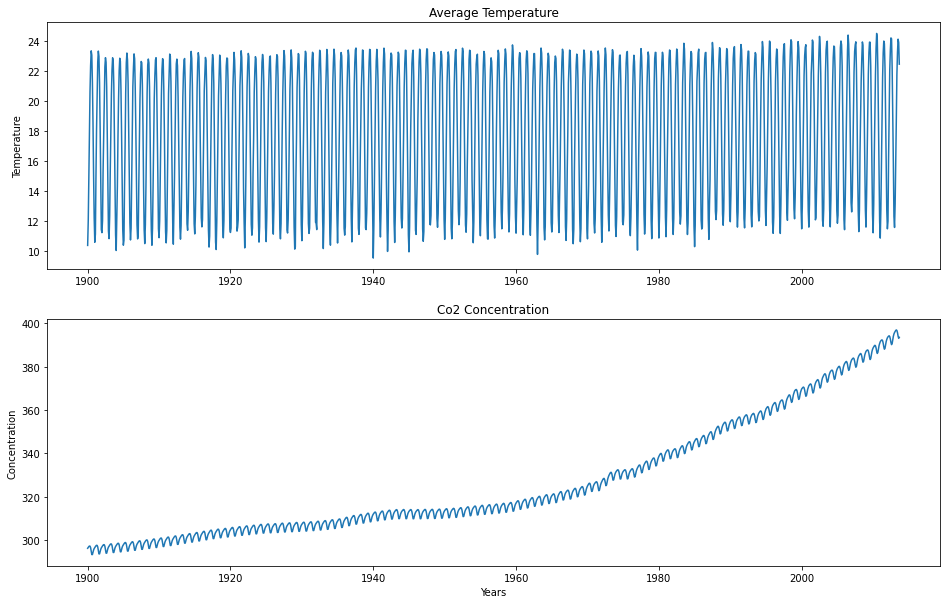

In [112]:
plt.figure(figsize=(16,10))
ax1 = plt.subplot2grid((2,2), (0,0), colspan=2)
ax2 = plt.subplot2grid((2,2), (1,0), colspan=2)

#Plotting Average Temperature
ax1.plot(dataset.AverageTemperature)
ax1.set_title('Average Temperature')
ax1.set_ylabel('Temperature')

#Plotting Average Temperature Uncertainty
ax2.plot(dataset.data_mean_global)
ax2.set_title('Co2 Concentration')
ax2.set_xlabel('Years')
ax2.set_ylabel('Concentration')
plt.show()

## Summary Statistics

An Adfuller test is going to be our best tool to determine if the series is stationary or not. We will also use the normal test to evaluate in the data is Gaussian (looks like) or not so we can reject the null hypothesis.

In [113]:
# Testing if the sample differ from a normal distribution (source: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html)

k2, p = stats.normaltest(dataset.AverageTemperature.values, nan_policy='omit')
alpha = .05
if p > alpha:
    print('Data looks Gaussian (fail to reject null hypothesis)')
else:
    print('Data looks non-Gaussian (reject null hypothesis')

Data looks non-Gaussian (reject null hypothesis


In [114]:
print(k2, p)

14267.072488493051 0.0


In [115]:
k2, p = stats.normaltest(dataset.data_mean_global.values,  nan_policy='omit')
alpha = .05
if p > alpha:
    print('Data looks Gaussian (fail to reject null hypothesis)')
else:
    print('Data looks non-Gaussian (reject null hypothesis')

Data looks non-Gaussian (reject null hypothesis


In [116]:
print(k2, p)

157.41913716445387 6.559469118115403e-35


There is a relation with time given the p_values.

count    1365.000000
mean       17.831976
std         4.424378
min         9.524213
25%        13.969703
50%        18.340751
75%        22.095679
max        24.524913
Name: AverageTemperature, dtype: float64

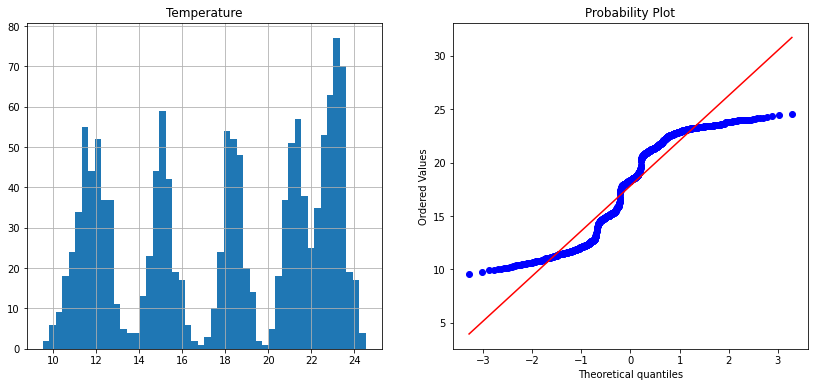

In [118]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
dataset['AverageTemperature'].hist(bins=50)
plt.title('Temperature')
plt.subplot(1,2,2)
stats.probplot(dataset['AverageTemperature'], plot=plt);
dataset.AverageTemperature.describe().T

The distribution plot shows four big concentrations of the temperature. It can be explained due to the seasons (summer and winter) but also because the winter in south hemisphere tends to be hotter and the winter in north hemisphere tend to be cooler.

count    1365.000000
mean      326.989877
std        27.314954
min       293.303981
25%       306.493611
50%       315.129158
75%       345.112579
max       396.999848
Name: data_mean_global, dtype: float64

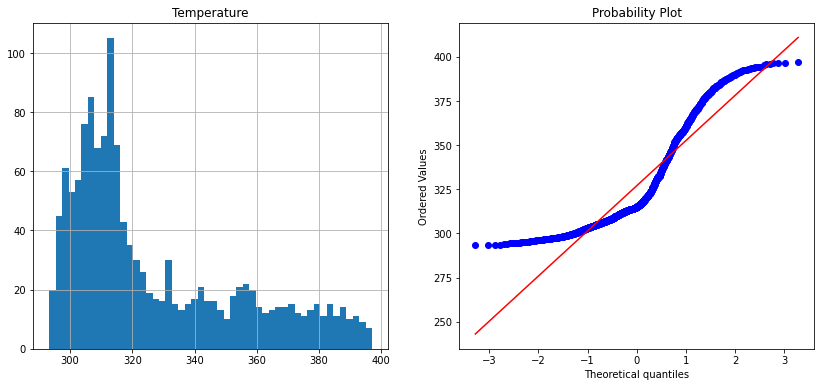

In [119]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
dataset['data_mean_global'].hist(bins=50)
plt.title('Temperature')
plt.subplot(1,2,2)
stats.probplot(dataset['data_mean_global'], plot=plt);
dataset.data_mean_global.describe().T

The main distribution of the $CO_2$ concentration is around 300. As this concentration for decades was steady around this value, it makes sense this plot.

Looking at the two variables together, below a correlation map will be displayed to investigae if we can infer some correlation, before the causal analysis.

In [121]:
dataset.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,AverageTemperature,data_mean_global
AverageTemperature,1.00,0.05
data_mean_global,0.05,1.00


The pearson correlation seems to be not useful for the present work. 5% of correlation is not relevant at a glance.

The next step, some model parameters will be defined.

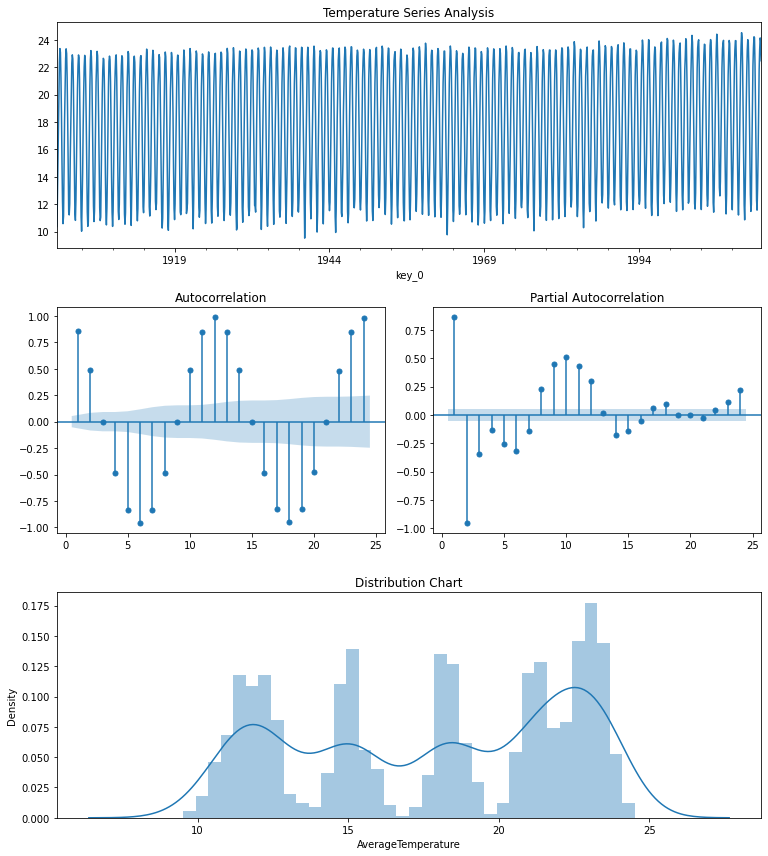

In [123]:
# Define model parameters
lags_plots = 24
figsize=(16,12)

# Creating plots of the DF
y = pd.Series(dataset.AverageTemperature)
fig = plt.figure()

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((3, 3), (1, 0))
ax3 = plt.subplot2grid((3, 3), (1, 1))
ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)

y.plot(ax=ax1, figsize=figsize)
ax1.set_title('Temperature Series Analysis')
plot_acf(y, lags=lags_plots, zero=False, ax=ax2);
plot_pacf(y, lags=lags_plots, zero=False, ax=ax3);
sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4)
ax4.set_title('Distribution Chart')

plt.tight_layout()

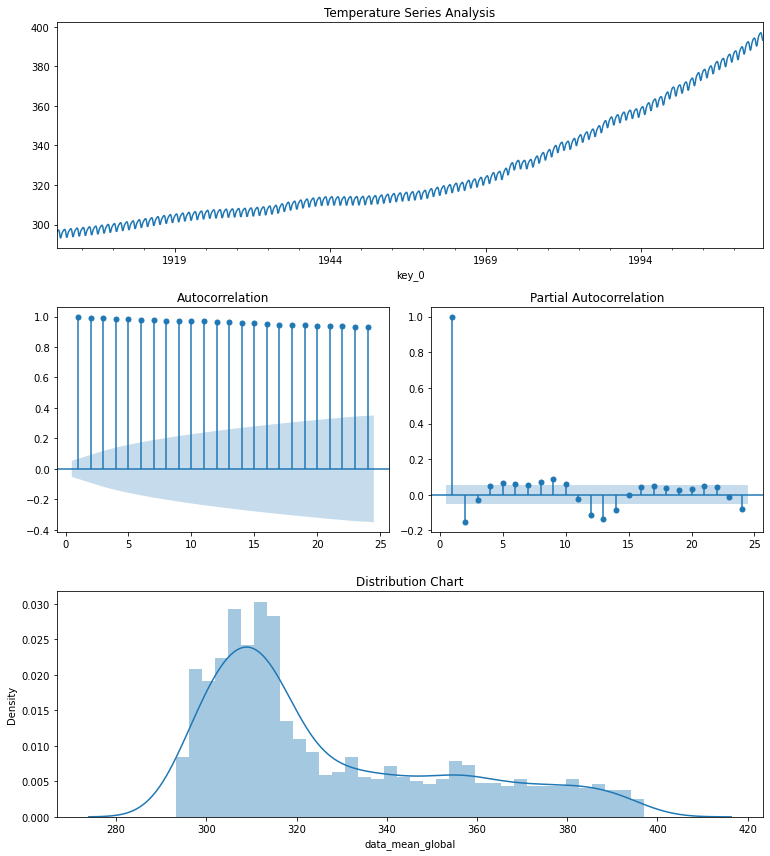

In [124]:
# Define model parameters
lags_plots = 24
figsize=(16,12)

# Creating plots of the DF
y = pd.Series(dataset.data_mean_global)
fig = plt.figure()

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((3, 3), (1, 0))
ax3 = plt.subplot2grid((3, 3), (1, 1))
ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)

y.plot(ax=ax1, figsize=figsize)
ax1.set_title('Temperature Series Analysis')
plot_acf(y, lags=lags_plots, zero=False, ax=ax2);
plot_pacf(y, lags=lags_plots, zero=False, ax=ax3);
sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4)
ax4.set_title('Distribution Chart')

plt.tight_layout()

In [165]:
# Splitting the dataset into train, validation and test to perform walk forward and back test

train_set = dataset[0:-12]
val_set   = dataset[-12:]

print(train_set.shape, val_set.shape)

(1353, 2) (12, 2)


In [166]:
def adfuller_test(X):
    # Applying Adfuller test to indentify stationarity in the serie
    # Source: https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html
    adfuller_resp2 = adfuller(X)

    adfuller_analysis2 = pd.Series(adfuller_resp2[0:4], 
                                  index=['ADF Statistic','p-value','Lags','# Observations'])
    adfuller_analysis2 = round(adfuller_analysis2,5)

    for key, value in adfuller_resp2[4].items():
            adfuller_analysis2["Critical Value (%s)"%key] = value.round(5)

    if adfuller_analysis2[0] < adfuller_analysis2[5]:
        print('The presented series seems stationary.\n')
    else:
        print('The series seems to be non-stationary.\n')
    print(adfuller_analysis2)
    
# inverting transformation
def invert_transformation(X_train, pred):
    forecast = pred.copy()
    columns = X_train.columns
    for col in columns:
        forecast[str(col)+'_pred'] = X_train[col].iloc[-1] + forecast[str(col)+'_pred'].cumsum()
    return forecast

def MAE(y, y_pred):
    return mean_absolute_error(y, y_pred)

def plot_series(y, y_pred, title='Plot Results', y_label='Y', x_label='X'):
    # Plot configs
    plt.figure(figsize=(20,8))
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.plot(y.index, y.values)
    plt.plot(y.index, y_pred, color='red')
    # Legend handling
    red_patch = mpatches.Patch(color='red', label='Predicted Temperature')
    blue_patch = mpatches.Patch(color='blue', label='Real Temperature')
    plt.legend(handles=[red_patch, blue_patch])
    plt.show()

In [167]:
adfuller_test(train_set.AverageTemperature)

The series seems to be non-stationary.

ADF Statistic             -1.28376
p-value                    0.63657
Lags                      24.00000
# Observations          1328.00000
Critical Value (1%)       -3.43528
Critical Value (5%)       -2.86372
Critical Value (10%)      -2.56793
dtype: float64


In [168]:
adfuller_test(train_set.data_mean_global)

The series seems to be non-stationary.

ADF Statistic              3.13206
p-value                    1.00000
Lags                      24.00000
# Observations          1328.00000
Critical Value (1%)       -3.43528
Critical Value (5%)       -2.86372
Critical Value (10%)      -2.56793
dtype: float64


In [169]:
# Data is non-stationary

In [170]:
train_set_diff = train_set.diff(2).dropna()
train_set_diff.head()

,AverageTemperature,data_mean_global
key_0,,
1900-03-01,4.378196,0.774323
1900-04-01,5.740011,0.628545
1900-05-01,5.879324,0.224367
1900-06-01,4.573726,-0.756625
1900-07-01,2.735925,-2.332125


In [171]:
adfuller_test(train_set_diff.AverageTemperature)

The presented series seems stationary.

ADF Statistic            -12.31840
p-value                    0.00000
Lags                      24.00000
# Observations          1326.00000
Critical Value (1%)       -3.43529
Critical Value (5%)       -2.86372
Critical Value (10%)      -2.56793
dtype: float64


In [172]:
adfuller_test(train_set_diff.data_mean_global)

The series seems to be non-stationary.

ADF Statistic             -2.52898
p-value                    0.10858
Lags                      23.00000
# Observations          1327.00000
Critical Value (1%)       -3.43529
Critical Value (5%)       -2.86372
Critical Value (10%)      -2.56793
dtype: float64


After setting the difference the series are stationary.

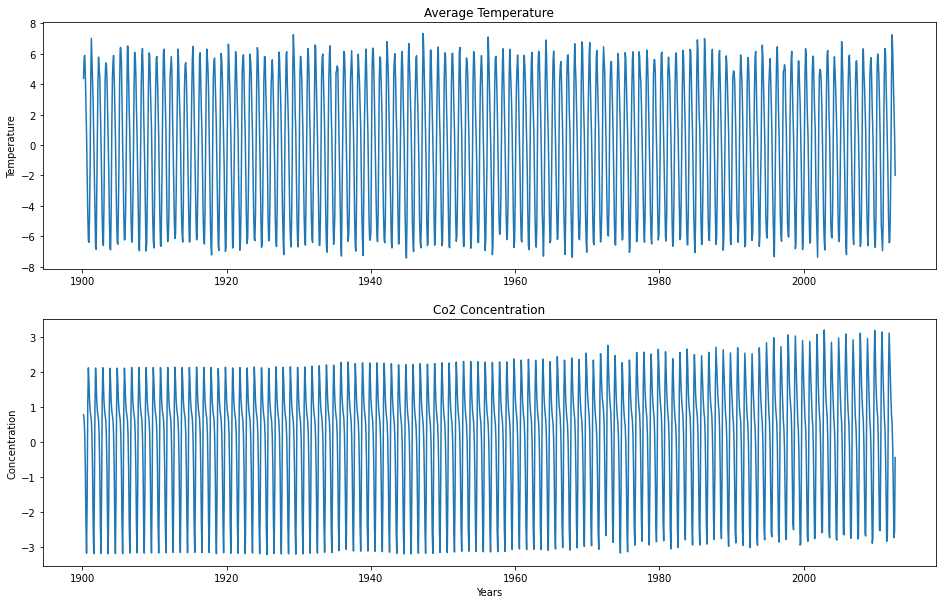

In [173]:
plt.figure(figsize=(16,10))
ax1 = plt.subplot2grid((2,2), (0,0), colspan=2)
ax2 = plt.subplot2grid((2,2), (1,0), colspan=2)

#Plotting Average Temperature
ax1.plot(train_set_diff.AverageTemperature)
ax1.set_title('Average Temperature')
ax1.set_ylabel('Temperature')

#Plotting Average Temperature Uncertainty
ax2.plot(train_set_diff.data_mean_global)
ax2.set_title('Co2 Concentration')
ax2.set_xlabel('Years')
ax2.set_ylabel('Concentration')
plt.show()

To better understand the causality aspect (precedence), we propose to use the Granger Causality to extend this work in this direction.

The [Granger Causality test](https://en.wikipedia.org/wiki/Granger_causality) is an test for determining whether or not one time series can be used to forecast another one. In fact, the Granger-causality is better described as precedence as it does not test if $Y$ causes $X$, but if $Y$ forecasts $X$

Then, the code below is in order to give us a table similar to the usual correlation map where the features appears at the rows and columns, but the value for this causal study is the $p- value$

In [174]:
# Source: https://stackoverflow.com/questions/58005681/is-it-possible-to-run-a-vector-autoregression-analysis-on-a-large-gdp-data-with
# Source: https://en.wikipedia.org/wiki/Granger_causality
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12

test = 'ssr-chi2test'

def grangers_causality_matrix(data, variables, test = 'ssr_chi2test', verbose=False):

    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)

    for c in dataset.columns:
        for r in dataset.index:
            test_result = grangercausalitytests(data[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],5) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')

            min_p_value = np.min(p_values)
            dataset.loc[r,c] = min_p_value

    dataset.columns = [var + '_x' for var in variables]

    dataset.index = [var + '_y' for var in variables]

    return dataset
columns = ['AverageTemperature', 'data_mean_global']
grangers_causality_matrix(dataset, variables = columns, verbose=False)

,AverageTemperature_x,data_mean_global_x
AverageTemperature_y,1.0,0.0
data_mean_global_y,0.0,1.0


Looking at the table, we can interprete as the $p-value$ of a given variable with sufix $y$ and other $x$. And it states that the $x$ variable Granger-causes variable $y$. With that said, we can reject the null hypotheses and in fact, the CO$_2$ concentration causes the increase of the temperature.

In [175]:
model = VAR(train_set_diff)
resp = model.fit(3)
print(resp.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 10, Nov, 2020
Time:                     15:02:08
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -3.48087
Nobs:                     1348.00    HQIC:                  -3.51469
Log likelihood:          -1428.91    FPE:                  0.0291606
AIC:                     -3.53494    Det(Omega_mle):       0.0288601
--------------------------------------------------------------------
Results for equation AverageTemperature
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                        -0.135791         0.017807           -7.626           0.000
L1.AverageTemperature         1.152324         0.023626           48.773           0.000
L1.data_mean_gl

In [176]:
# Get the lag order
lag_order = resp.k_ar
print(lag_order)

# Input data for forecasting
input_data = train_set_diff.values[-lag_order:]
print(input_data)

3
[[ 2.13644359 -2.73311016]
 [ 0.74342593 -2.56160778]
 [-1.9955339  -0.44445031]]


In [177]:
len(val_set)

12

In [178]:
# forecasting
pred = resp.forecast(y=input_data, steps=12)
pred = (pd.DataFrame(pred, index=val_set.index, columns=val_set.columns + '_pred'))
print(pred)

            AverageTemperature_pred  data_mean_global_pred
key_0                                                     
2012-10-01                -4.647823               1.728082
2012-11-01                -6.396114               2.304985
2012-12-01                -5.779297               1.498971
2013-01-01                -2.629942               0.631863
2013-02-01                 1.374684               0.650710
2013-03-01                 4.206623               1.198885
2013-04-01                 5.020119               1.116488
2013-05-01                 4.402525              -0.170219
2013-06-01                 3.358949              -1.898546
2013-07-01                 2.194246              -2.659834
2013-08-01                 0.459483              -1.783307
2013-09-01                -2.093801               0.023662


In [180]:
output = invert_transformation(val_set, pred)

In [181]:
output

,AverageTemperature_pred,data_mean_global_pred
key_0,,
2012-10-01,17.825398,395.316602
2012-11-01,11.429284,397.621586
2012-12-01,5.649987,399.120557
2013-01-01,3.020045,399.752420
2013-02-01,4.394729,400.403130
2013-03-01,8.601352,401.602015
2013-04-01,13.621471,402.718503
2013-05-01,18.023996,402.548284
2013-06-01,21.382945,400.649738


In [182]:
val_set

,AverageTemperature,data_mean_global
key_0,,
2012-10-01,19.279076,392.481832
2012-11-01,15.856503,394.071891
2012-12-01,12.302560,395.124614
2013-01-01,11.567652,395.804187
2013-02-01,13.144059,396.332432
2013-03-01,15.551185,396.737347
2013-04-01,18.668117,396.999848
2013-05-01,21.748558,396.761681
2013-06-01,23.263550,395.727238


In [194]:
results = pd.merge(val_set, output, left_on=val_set.index, right_on=output.index)
results = results.set_index('key_0')
results

,AverageTemperature,data_mean_global,AverageTemperature_pred,data_mean_global_pred
key_0,,,,
2012-10-01,19.279076,392.481832,17.825398,395.316602
2012-11-01,15.856503,394.071891,11.429284,397.621586
2012-12-01,12.302560,395.124614,5.649987,399.120557
2013-01-01,11.567652,395.804187,3.020045,399.752420
2013-02-01,13.144059,396.332432,4.394729,400.403130
2013-03-01,15.551185,396.737347,8.601352,401.602015
2013-04-01,18.668117,396.999848,13.621471,402.718503
2013-05-01,21.748558,396.761681,18.023996,402.548284
2013-06-01,23.263550,395.727238,21.382945,400.649738


In [195]:
mae_temp = MAE(results.AverageTemperature, results.AverageTemperature_pred)
print(f'The MAE of the Temperature for the VAR model is {round(mae_temp,4)} degrees.')

The MAE of the Temperature for the VAR model is 4.0535 degrees.


In [196]:
mae_conc = MAE(results.data_mean_global, results.data_mean_global_pred)
print(f'The MAE of the CO2 Concentration for the VAR model is {round(mae_conc,4)}.')

The MAE of the CO2 Concentration for the VAR model is 4.1014.


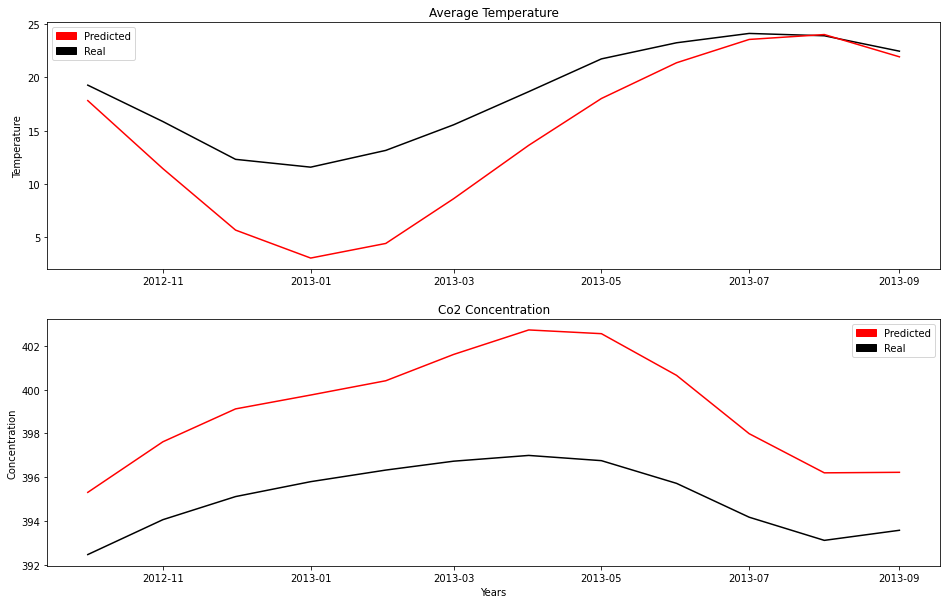

In [199]:
plt.figure(figsize=(16,10))
ax1 = plt.subplot2grid((2,2), (0,0), colspan=2)
ax2 = plt.subplot2grid((2,2), (1,0), colspan=2)

#Plotting Average Temperature
ax1.plot(results.AverageTemperature, color='black')
ax1.plot(results.AverageTemperature_pred, color='red')
ax1.set_title('Average Temperature')
ax1.set_ylabel('Temperature')
# Legend handling
red_patch = mpatches.Patch(color='red', label='Predicted')
blue_patch = mpatches.Patch(color='black', label='Real')
ax1.legend(handles=[red_patch, blue_patch])

#Plotting Average Temperature Uncertainty
ax2.plot(results.data_mean_global, color='black')
ax2.plot(results.data_mean_global_pred, color='red')
ax2.set_title('Co2 Concentration')
ax2.set_xlabel('Years')
ax2.set_ylabel('Concentration')

# Legend handling
red_patch = mpatches.Patch(color='red', label='Predicted')
blue_patch = mpatches.Patch(color='black', label='Real')
ax2.legend(handles=[red_patch, blue_patch])

plt.show()

## Conclusion

In this analysis it was investigated the correlation and the causal indication of the temperature and $CO_2$ concentration. The correlation does not play an important role, but the Grangers-causal test was positive.

After this conclusion, a Vector Autoregression model was instanciated to study both time series and we could overcome the baseline model, but further improvements are important such as adding more important features and other methods. Adding other features, we can start thinking about using a Supervised Learning and a regression algorithm or even a deep learning approach to investigate the error generated by these methods.